# Playing Chess with SARFA

This notebook teaches how to use [SARFA](https://arxiv.org/abs/1912.12191) to interpret an RL agent. 

Here we are interpreting moves by the prominent chess engines(e.g. Stockfish). 

In [1]:
# Import SARFA saliency attributor to interpret
import sarfa_saliency

## Setting up chess environment and loading chess playing agent

First we will setup the RL environment and initiate the agent.

In [2]:
# Set up environment and agent

import chess #version: 0.27.3
import chess.uci
import time

# Loading chess engine 
# Note : You might have to give permission to run the engine as an application

handler = chess.uci.InfoHandler()


# Engine appropriate for operating system is chosen
from sys import platform as _platform

if _platform == "linux" or _platform == "linux2":
    engine = chess.uci.popen_engine('engines/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64')

elif _platform == "darwin":
    engine = chess.uci.popen_engine('engines/stockfish-11-mac/stockfish-11-mac/Mac/stockfish-11-64')

elif _platform == "win32":
    engine = chess.uci.popen_engine('engines/stockfish-11-win/stockfish-11-win/Windows/stockfish_20011801_32bit.exe') 

elif _platform == "win64":
    engine = chess.uci.popen_engine('engines/stockfish-11-win/stockfish-11-win/Windows/stockfish_20011801_x64.exe')

# To use other engines like Leela-Chess-Zero give path to the engine 

engine.setoption({'MultiPV': 100})
engine.info_handlers.append(handler)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The chess.uci module is deprecated in favor of
chess.engine <https://python-chess.readthedocs.io/en/latest/engine.html>.

Please consider updating and open an issue
<https://github.com/niklasf/python-chess/issues/new> if your use case
is not covered by the new API.
  after removing the cwd from sys.path.


## Getting Agent's evaluation of state

Let's define a function which evaluates a given state in terms of Q-values, and also returns the best move.

In [3]:
from collections import defaultdict

def get_dict_q_vals(board, legal_moves, eval_time, original_move):
    """
    Function returns Q-values in given board position
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
        original_move: original best move (chess.Move()) 
    Output:
        q_vals_dict: Dictionary containing Q-values and Actions
        bestmove: chess.Move() - Best move in given board position
    """
    
    i = 0
    q_vals_dict = {}
    
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)

    print('querying engine with perturbed position')
    engine.position(board)
    evaluation = engine.go(movetime=eval_time)
    # print(evaluation)
    if original_move is None:
        # no initial move supplied
        original_move = evaluation.bestmove
    dict_moves_to_score = defaultdict(int)
    
    for move_id in handler.info['pv'].keys():
        move_string = str(handler.info['pv'][move_id][0])
        move_score = 0
        if handler.info["score"][move_id].cp is None:
            mate_in_moves = handler.info["score"][move_id].mate
            if mate_in_moves > 0:
                # white will win in some number of moves
                move_score = 40
            else:
                # black will win 
                move_score = -40
        else:
            move_score = round(handler.info["score"][move_id].cp/100.0,2)
        dict_moves_to_score[move_string] = move_score
    
    # print(dict_moves_to_score)
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            score = dict_moves_to_score[str(el)]
            q_vals_dict[el.uci()] = score
    
    return q_vals_dict, evaluation.bestmove

## Computing saliency using SARFA

SARFA is a perturbation-based saliency attribution. We first perturb the state and evaluate the perturbed state.  Then, comparing with original evaluation, we  assign saliency to particular feature.

We already have defined function to evaluate a state. Now we need to incorporate - 1.  perturbation, 2. computation of saliency using _sarfa_saliency_ module. 


In [4]:
def computeSaliency(FEN = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'):
    """
    Function returns saliency map for given board position  
    Input:
        FEN : Board position encoded in a FEN  
    Output:
        answer : Saliency for each location on the board
    """

    print("***********************", FEN, "**********************")
    board = chess.Board(FEN)
    evaltime = 6000
    legal_moves = list(board.legal_moves)[:]

    # Q-values for original state
    dict_q_values_before_perturbation, original_move  = get_dict_q_vals(board, legal_moves, evaltime, None)
    print('original move = ', original_move)
    
    # Saliency for each board location
    answer = {
        'a1' : {'int': chess.A1, 'saliency': -2},
        'a2' : {'int': chess.A2, 'saliency': -2},
        'a3' : {'int': chess.A3, 'saliency': -2},
        'a4' : {'int': chess.A4, 'saliency': -2},
        'a5' : {'int': chess.A5, 'saliency': -2},
        'a6' : {'int': chess.A6, 'saliency': -2},
        'a7' : {'int': chess.A7, 'saliency': -2},
        'a8' : {'int': chess.A8, 'saliency': -2},
        'b1' : {'int': chess.B1, 'saliency': -2},
        'b2' : {'int': chess.B2, 'saliency': -2},
        'b3' : {'int': chess.B3, 'saliency': -2},
        'b4' : {'int': chess.B4, 'saliency': -2},
        'b5' : {'int': chess.B5, 'saliency': -2},
        'b6' : {'int': chess.B6, 'saliency': -2},
        'b7' : {'int': chess.B7, 'saliency': -2},
        'b8' : {'int': chess.B8, 'saliency': -2},
        'c1' : {'int': chess.C1, 'saliency': -2},
        'c2' : {'int': chess.C2, 'saliency': -2},
        'c3' : {'int': chess.C3, 'saliency': -2},
        'c4' : {'int': chess.C4, 'saliency': -2},
        'c5' : {'int': chess.C5, 'saliency': -2},
        'c6' : {'int': chess.C6, 'saliency': -2},
        'c7' : {'int': chess.C7, 'saliency': -2},
        'c8' : {'int': chess.C8, 'saliency': -2},
        'd1' : {'int': chess.D1, 'saliency': -2},
        'd2' : {'int': chess.D2, 'saliency': -2},
        'd3' : {'int': chess.D3, 'saliency': -2},
        'd4' : {'int': chess.D4, 'saliency': -2},
        'd5' : {'int': chess.D5, 'saliency': -2},
        'd6' : {'int': chess.D6, 'saliency': -2},
        'd7' : {'int': chess.D7, 'saliency': -2},
        'd8' : {'int': chess.D8, 'saliency': -2},
        'e1' : {'int': chess.E1, 'saliency': -2},
        'e2' : {'int': chess.E2, 'saliency': -2},
        'e3' : {'int': chess.E3, 'saliency': -2},
        'e4' : {'int': chess.E4, 'saliency': -2},
        'e5' : {'int': chess.E5, 'saliency': -2},
        'e6' : {'int': chess.E6, 'saliency': -2},
        'e7' : {'int': chess.E7, 'saliency': -2},
        'e8' : {'int': chess.E8, 'saliency': -2},
        'f1' : {'int': chess.F1, 'saliency': -2},
        'f2' : {'int': chess.F2, 'saliency': -2},
        'f3' : {'int': chess.F3, 'saliency': -2},
        'f4' : {'int': chess.F4, 'saliency': -2},
        'f5' : {'int': chess.F5, 'saliency': -2},
        'f6' : {'int': chess.F6, 'saliency': -2},
        'f7' : {'int': chess.F7, 'saliency': -2},
        'f8' : {'int': chess.F8, 'saliency': -2},
        'g1' : {'int': chess.G1, 'saliency': -2},
        'g2' : {'int': chess.G2, 'saliency': -2},
        'g3' : {'int': chess.G3, 'saliency': -2},
        'g4' : {'int': chess.G4, 'saliency': -2},
        'g5' : {'int': chess.G5, 'saliency': -2},
        'g6' : {'int': chess.G6, 'saliency': -2},
        'g7' : {'int': chess.G7, 'saliency': -2},
        'g8' : {'int': chess.G8, 'saliency': -2},
        'h1' : {'int': chess.H1, 'saliency': -2},
        'h2' : {'int': chess.H2, 'saliency': -2},
        'h3' : {'int': chess.H3, 'saliency': -2},
        'h4' : {'int': chess.H4, 'saliency': -2},
        'h5' : {'int': chess.H5, 'saliency': -2},
        'h6' : {'int': chess.H6, 'saliency': -2},
        'h7' : {'int': chess.H7, 'saliency': -2},
        'h8' : {'int': chess.H8, 'saliency': -2},

        }
    
    # Iteratively perturb each feature on the board
    # Note : Perturbations should be valid. Code for avoiding those cases.
    
    for square_string in sorted(answer.keys()):
        entry = answer[square_string]
        entry_keys = ['saliency', 'dP', 'K', 'QMaxAnswer', 'actionGapBeforePerturbation', 'actionGapAfterPerturbation']
        print('perturbing square = ', square_string)
        # perturb board
        piece_removed = board.remove_piece_at(entry['int'])
        
        if piece_removed is None:
            # square was empty, so proceed without changing anything
            print('square was empty, so skipped')
            # print(board)
            print('------------------------------------------')
        
            continue
        
        elif (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
            # illegal piece was removed
            print('illegal piece was removed')
            for key in entry_keys:
                entry[key] = 0
        else:
            # set perturbed state
            engine.position(board)

            # Check if the original move is still valid
            if board.is_legal(original_move):
                # Find the q values 
                dict_q_values_after_perturbation, _ = get_dict_q_vals(board, legal_moves, evaltime, original_move)
                
                # Compute saliency using sarfa_saliency methods
                entry['saliency'], entry['dP'], entry['K'], entry['QMaxAnswer'],\
                    entry['actionGapBeforePerturbation'], entry['actionGapAfterPerturbation']\
                         = sarfa_saliency.computeSaliencyUsingSarfa(str(original_move), dict_q_values_before_perturbation, dict_q_values_after_perturbation)
                print('saliency for this square = ', entry)
                
            else:
                # illegal original move in perturbed state, therefore piece removed is probably important 
                # print(board.is_legal(original_move))
                # print(board)
                print('original move illegal in perturbed state')
                for key in entry_keys:
                    entry[key] = -1
                entry['saliency'] = 1 
                
        # undo perturbation
        print('------------------------------------------')
                
        board.set_piece_at(entry['int'], piece_removed)
        

    print(answer)
    return(answer)

## Overlaying saliency map on the board

This depends on the environment you are computing saliency for. Here we will overlay the explanation generated using SARFA on the chess board.

In [5]:
# Cell for displaying board position

from IPython.display import Image, display
import cairosvg
import cv2
import svg_custom.svg_custom as svg_custom 
import matplotlib.pyplot as plt
import numpy as np

# Few utility functions
def svg_to_png(img):
    '''
    Converts given svg image to png
    Input : 
        img : image in .svg format 
    Output :
        svg_custom/board.png
        Display of image
    '''
    with open('svg_custom/board.svg', 'w+') as f:
        f.write(img)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')
    display(Image(filename='svg_custom/board.png'))

def display_board(board):
    '''
    Displaying given board
    Input : 
        board : chess.Board
    Output :
        svg_custom/board.png
        Display of image     
    '''
    img = svg_custom.board(board)
    svg_to_png(img)
    
def return_bestmove(board, eval_time = 6000):
    '''
    Returns and displays best move for a given chess position
    Input :
        board : chess.Board
    Output :
        bestmove : chess.Move 
    '''
    engine.position(board)
    bestmove =  engine.go(movetime=eval_time).bestmove
    print('Best move is', bestmove)
    
    svg_w_arrow = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])
    
    svg_to_png(svg_w_arrow)
    
    return bestmove

def explanation(board):
    '''
    Generates explanation of the best move for given board position using SARFA
    
    Input :
        board = chess.Board
    Output :
        prints piecewise saliency
        svg_custom/board.png
    '''
    
    bestmove =  engine.go(movetime=6000).bestmove

    # Evaluation of board position for best move
    evaluation = computeSaliency(chess.Board.fen(board))

    return evaluation, bestmove 

def generate_heatmap(evaluation, bestmove):
    """
    Generates heatmap for  saliency evaluation of the best move

    """
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    for position in evaluation:
        x, y = evaluation[position]['int']//8, evaluation[position]['int'] % 8
        heatmap[x, y] = evaluation[position]['saliency']
    heatmap = np.flipud(heatmap)
    

    #### Saliency map overlaid on board
    svg = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])

    with open('svg_custom/board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')

    # original board as a numpy array
    board_array = cv2.imread('svg_custom/board.png')

    threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)

    cv2.imwrite("svg_custom/board.png", board_array)
    print('------------===============------------===============\n\n')
    display(Image('svg_custom/board.png'))
    print('\n\n------------===============------------===============')

## Let's play a puzzle!

We have loaded a standard puzzle in the following cell. It's white's turn to play, try it out yourself! We will also ask chess engine to play the same.

### Extras :
You can setup the chess board using standard board editor like [Lichess Board Editor](https://lichess.org/editor) and copy the [FEN](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) of given position. 

**Note**:(For now, the code requires white to play. How to play with black then? You can always switch the colors in the editor.)

5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1


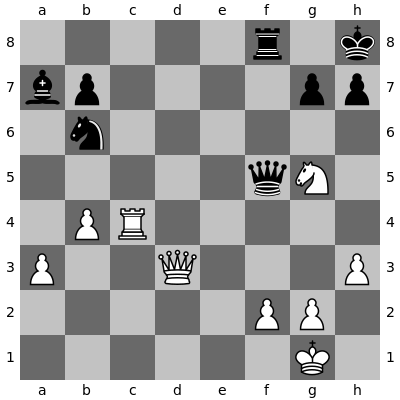

In [10]:
FEN = '5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1'

# Visulaize the board
board = chess.Board(FEN)
print(FEN)
display_board(board)


## What move is the engine planning to play?

Best move is g3g8


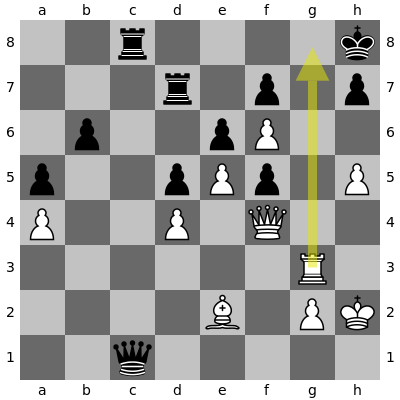

In [7]:
bestmove = return_bestmove(board)

### Were you planning to play the same? 
If yes, congrats! Confirm your strategy with SARFA once. And if no, let's figure out why it is a good move using SARFA. (See the output image.)

*********************** 2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1 **********************
querying engine with perturbed position
Total Legal Moves :  34
original move =  g3g8
perturbing square =  a1
square was empty, so skipped
------------------------------------------
perturbing square =  a2
square was empty, so skipped
------------------------------------------
perturbing square =  a3
square was empty, so skipped
------------------------------------------
perturbing square =  a4
querying engine with perturbed position
Total Legal Moves :  34
skipping original action for KL-Divergence
saliency for this square =  {'int': 24, 'saliency': 0.0019013962545279804, 'dP': 0.0009516849769775071, 'K': 0.916821591945741, 'QMaxAnswer': 0, 'actionGapBeforePerturbation': 8.879999999999999, 'actionGapAfterPerturbation': 7.27}
------------------------------------------
perturbing square =  a5
querying engine with perturbed position
Total Legal Moves :  34
skipping original action for

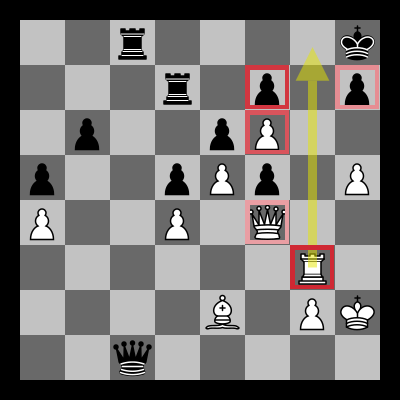



------------===============------------===============


In [8]:
evaluation, bestmove = explanation(board)
generate_heatmap(evaluation, bestmove)

## Interpreting the output

1. Output shows how important(salient) each piece is for current move (g2g4). The importance varies from darker red(more salient) to lighter red(less salient).

2. To interpret the result, think on the lines that if this piece were not there, agent would not have played the current move.
    For example, in the default chess puzzle, black's queen and pawns around it are highlighted. White playing g2g4 can thus be explained as trapping the black's queen in upcoming steps.

